# Visualizing And Evaluating Binocular Pupil Matching

This notebook has been created in order to evaluate existing and future implementations of the binocular pupil matching algorithm.

### Existing implementations

We compare 4 existing implementations:
- [`v1.18`](https://github.com/pupil-labs/pupil/tree/cf8b845d4491d0a845be77fbc5584277a3210e16)
- [PR `#1557` (monotonic gaze)](https://github.com/cboulay/pupil/tree/db16290fe1b7f5b8d0bc9a19d24b948b2c8aadfb)
- [PR `#1728` (without upsampling)](https://github.com/papr/pupil/tree/3ca5094ec8482ad49f718701ec45fe38c728ded8)
- [PR `#1731` (dynamic temporal cutoff)](https://github.com/romanroibu/pupil/tree/3395363f5b6417385775f0d9f903b2f8ae73fdb4)

## Setup

### Load Gaze Mapper implementations

In [1]:
from gaze_mappers import GAZE_MAPPERS

### Utility functions
These functions generate artifical pupil data with a fixed frame rate

In [2]:
from utils import (
    generate_monocular_pupil_data,
    generate_uniform_numbers,
    generate_timestamps,
    take,
)

### Mixing pupil data

We model the Pupil Capture pipeline by calculating an arrival time in the gaze mapper and mapping the pupil data in order of the arrival time.

The `arrival_time` is calculated with following values:
- `timestamp`: Pupil creation time, fixed fps
- `camera jitter`: Uniform random value, newly generated for each pupil datum, models slight variations in exposure timings
- `transport delay`: Fixed value added to each pupil datum, models delay from transferring the pupil data from the eye to the world process
- `transport jitter`: Uniform random value, newly generated for each pupil datum, models slight variations in transport timings

See `utils.custom_binocular_mixer()` for details.

In [15]:
from utils import custom_binocular_mixer

### Plotting functions
Functions for visualizing matched pupil and gaze data.

In [4]:
from utils import plot_mapped_gaze_data

### Example usage
1. Define pupil streams
2. Setup mixer, simulating transfer to world process
3. Intialise mapper
4. Map pupil data
5. Visualization

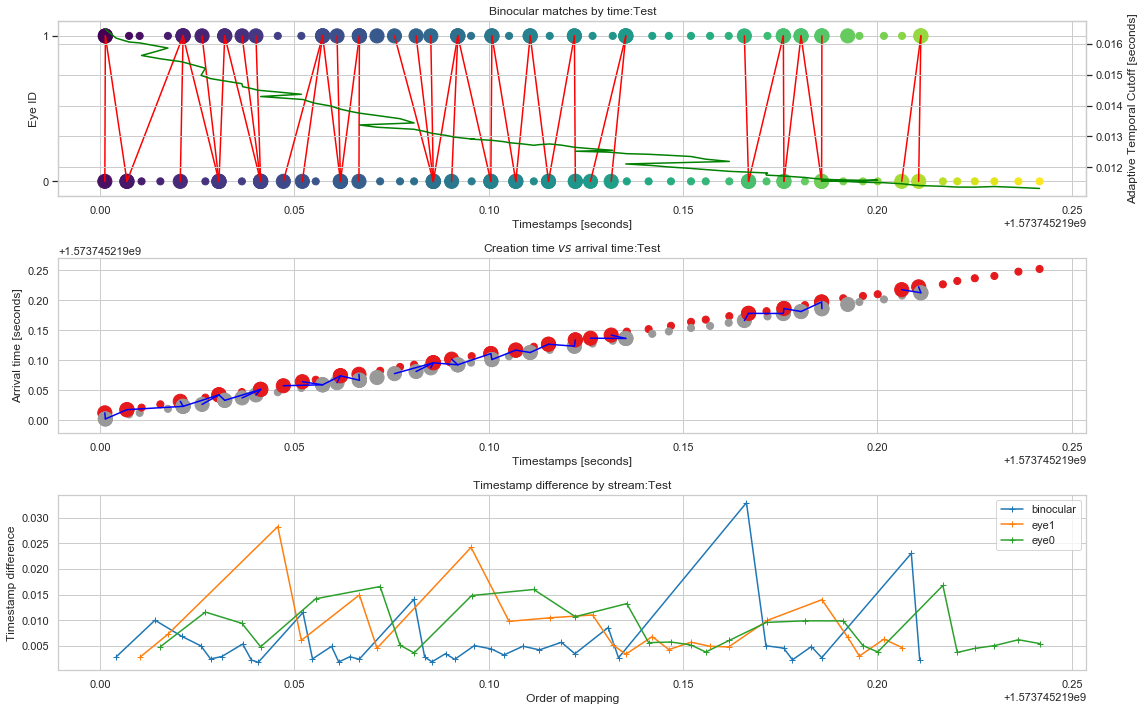

In [5]:
sample_count = 100
both_fps = 200


eye0 = generate_monocular_pupil_data(
    eye_id=0,
    confidences=generate_uniform_numbers(),
    timestamps=generate_timestamps(fps=both_fps,),
)


eye1 = generate_monocular_pupil_data(
    eye_id=1,
    confidences=generate_uniform_numbers(),
    timestamps=generate_timestamps(fps=both_fps,),
)

binocular_mixer = custom_binocular_mixer(
    sample_count=sample_count,
    both_camera_jitter_range=(0, 1 / (2 * both_fps)),
    both_transport_jitter_range=(0, 1 / (2 * both_fps)),
    eye0_transport_delay=0.01,
)

pupils = binocular_mixer(eye0, eye1)
pupil_list = take(sample_count, pupils)

test_mapper = GAZE_MAPPERS[-1]
mapped_data = test_mapper.map_batch(pupil_list)

plot_mapped_gaze_data(mapped_data, title="Test")

del pupil_list
del mapped_data
del test_mapper

#### Binocular matches by time
This graph visualizes which pupil datums are being matched to binocular gaze (red lines). Small dots represent low confidence data which should not be considered for binocular mapping and should be mapped monocularly as soon as possible. The dot color encodes the arrival time. The green line visualizes how the temporal cutoff changes over time.

#### Creation time vs arrival time
This graph visualizes how creation time relates to arrival time. Blue lines show binocular matches. Dot colors encode eye id.

#### Timestamps difference by stream
Binocular, monocular eye0, and monocular eye1 gaze data are considered seperate streams. This graph visualizes that the gaze for each stream is yielded in a monotonic fashion.

## Putting it all together

Functions for conveniently generating pupil streams, mixing, and mapping them.

In [6]:
from utils import evaluate_gaze_mappers

### Case 1: Ideal case
Same framerate, no jitter

v1_18_Binocular_Gaze_Mapper


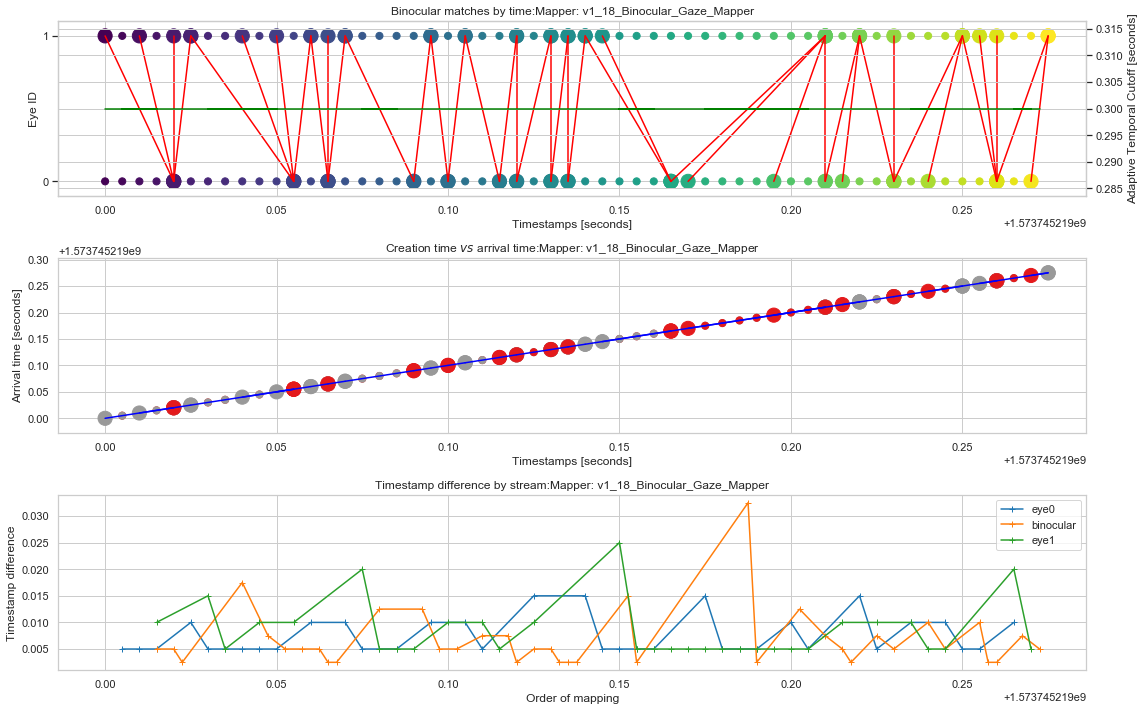

Monotonic_Binocular_Gaze_Mapper


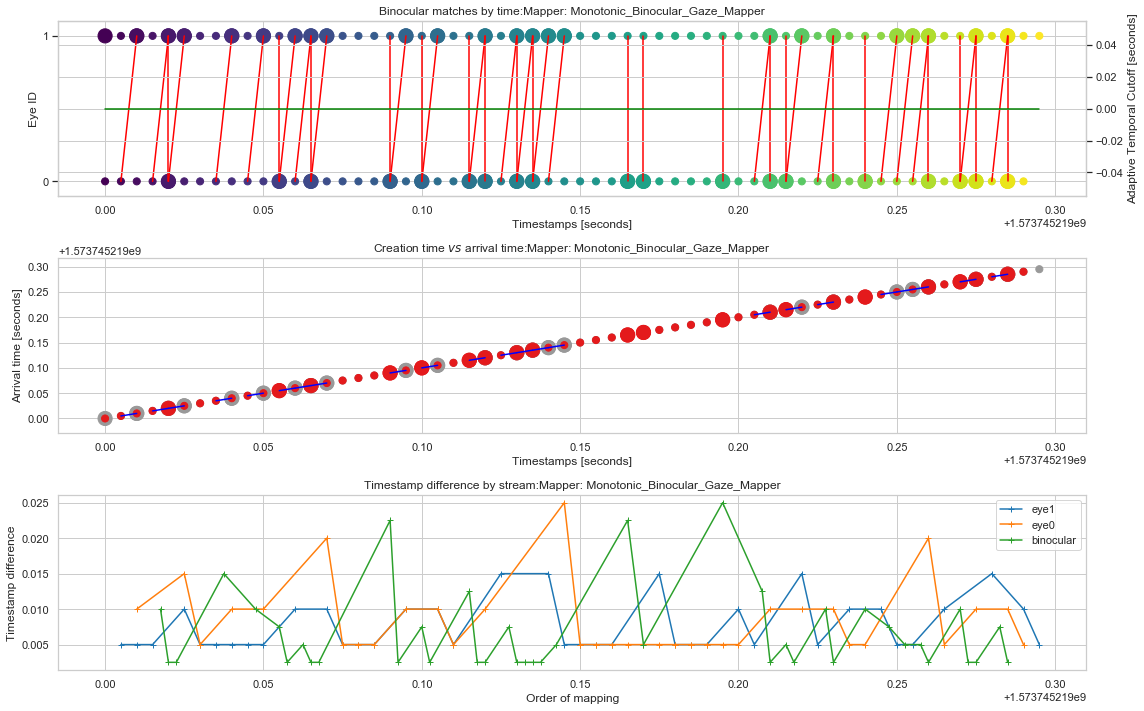

No_Upsampling_Binocular_Gaze_Mapper


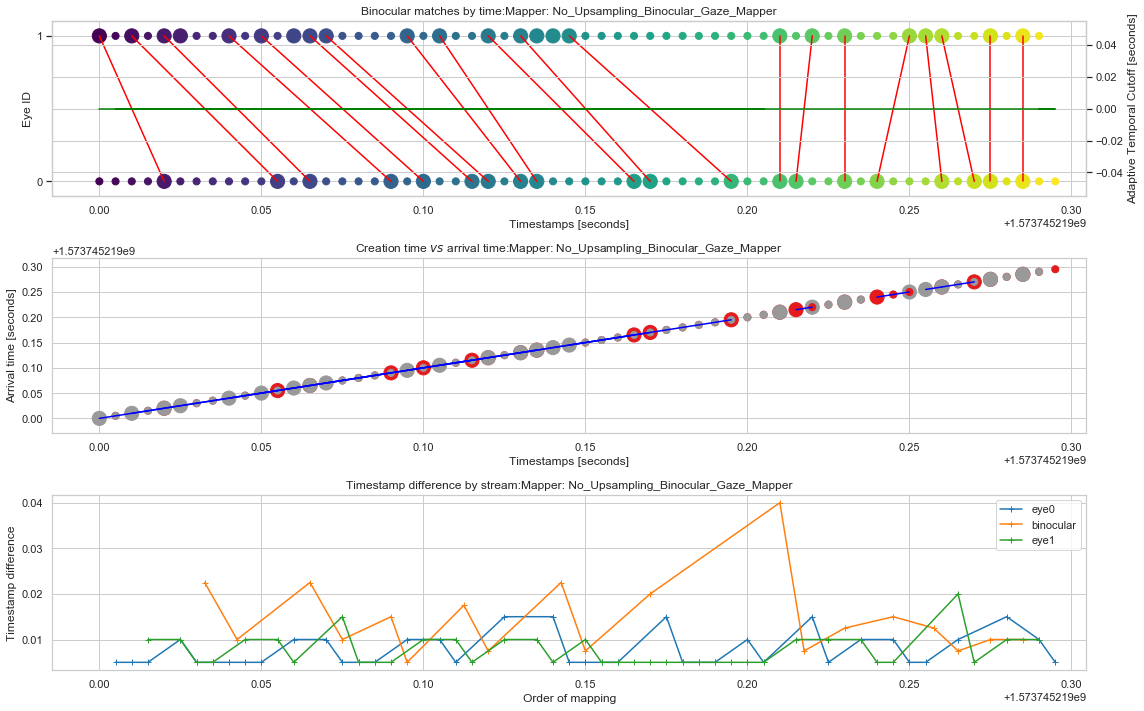

Dynamic_Cutoff_Binocular_Gaze_Mapper


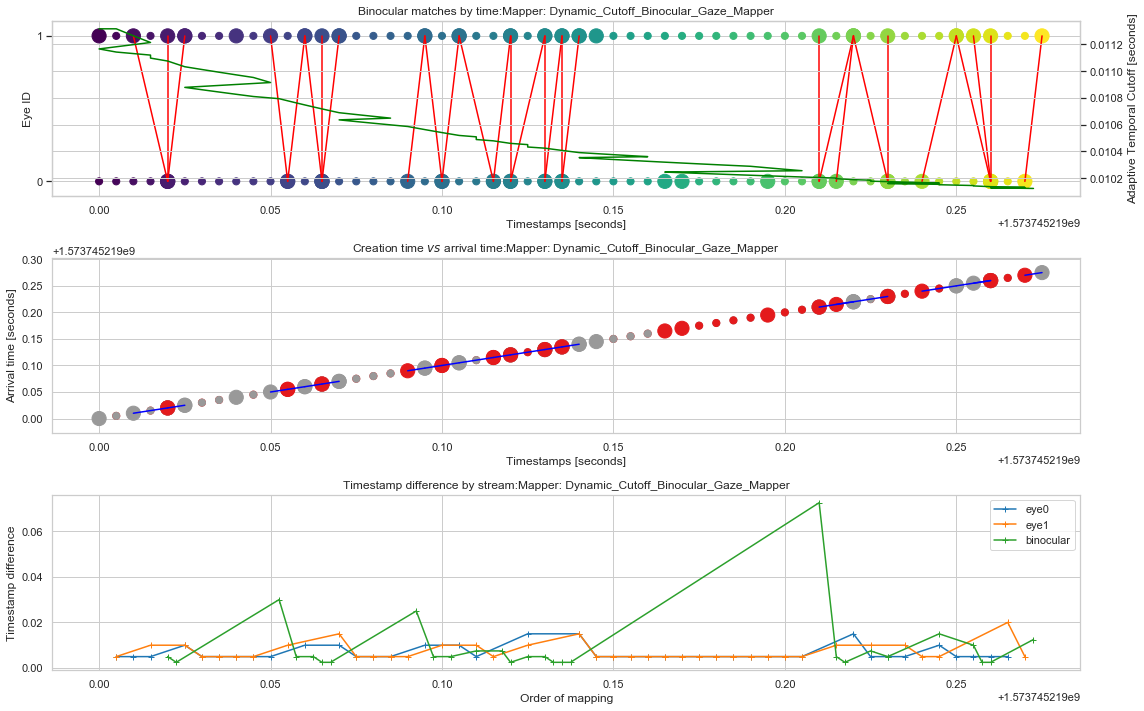

In [7]:
evaluate_gaze_mappers(
    both_timestamp_fps=200,
    binocular_data_mixer=custom_binocular_mixer(
        sample_count=sample_count,
        both_camera_jitter_range=(0, 0),
        both_transport_jitter_range=(0, 0),
        eye0_transport_delay=0.0,
    ),
    eye0_confidence_stream=generate_uniform_numbers(),
    eye1_confidence_stream=generate_uniform_numbers(),
)

### Case 2: Camera jitter
Same framerate, camera jitter on one eye

v1_18_Binocular_Gaze_Mapper


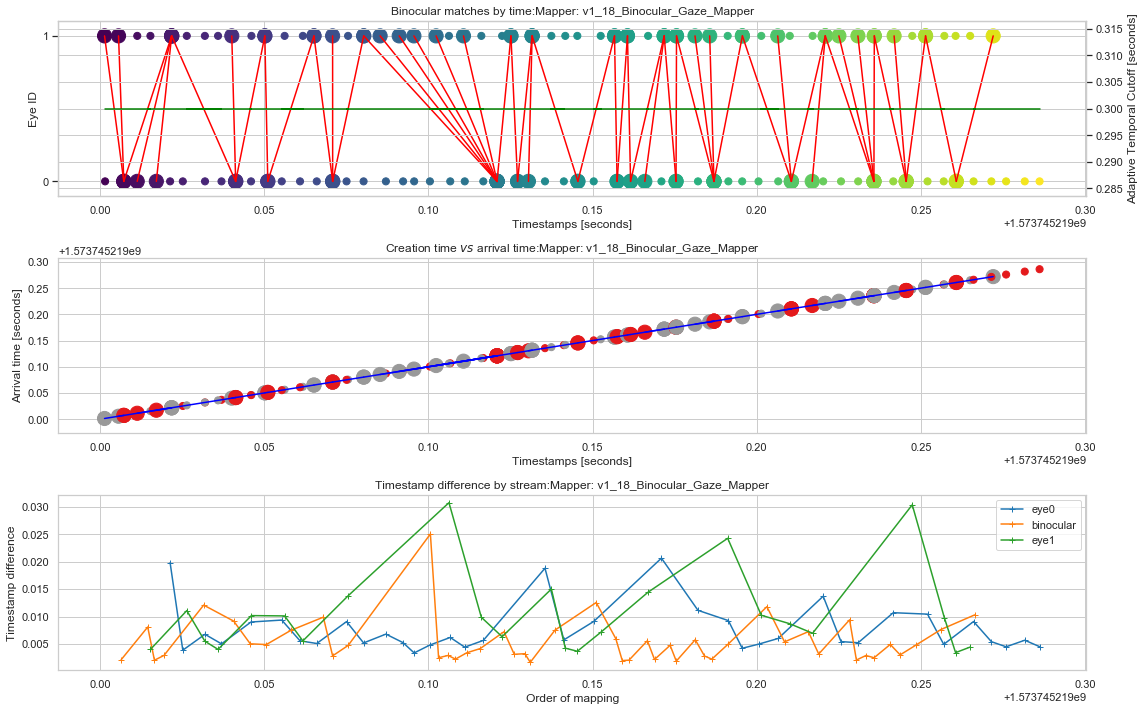

Monotonic_Binocular_Gaze_Mapper


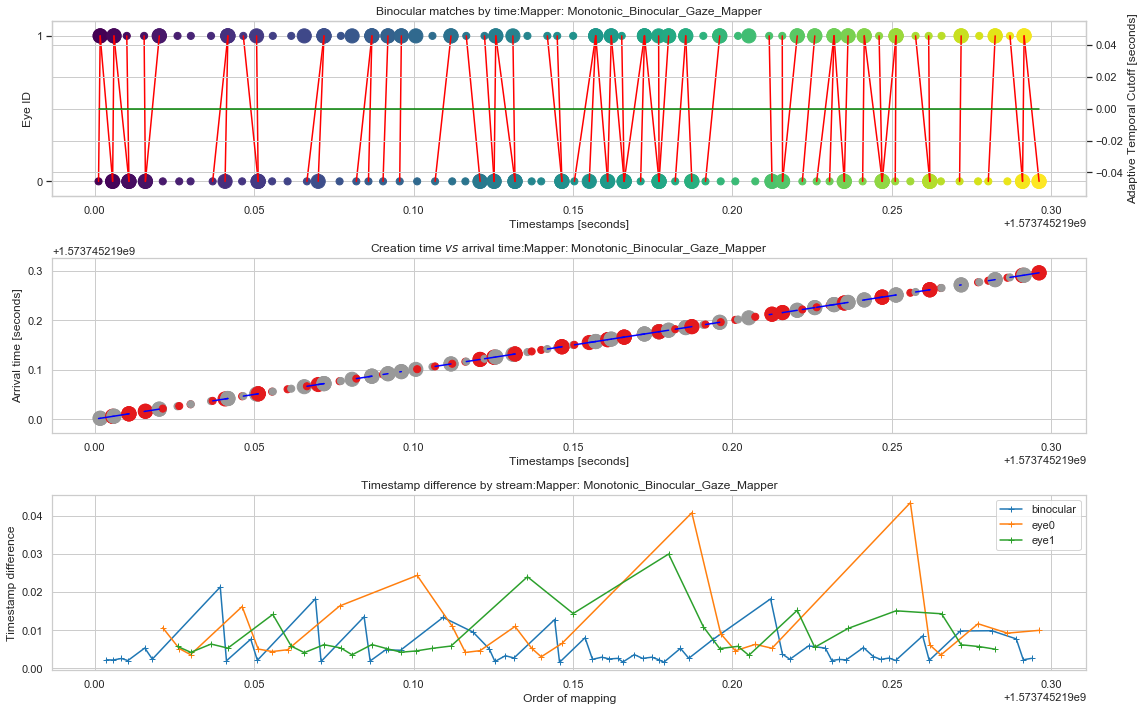

No_Upsampling_Binocular_Gaze_Mapper


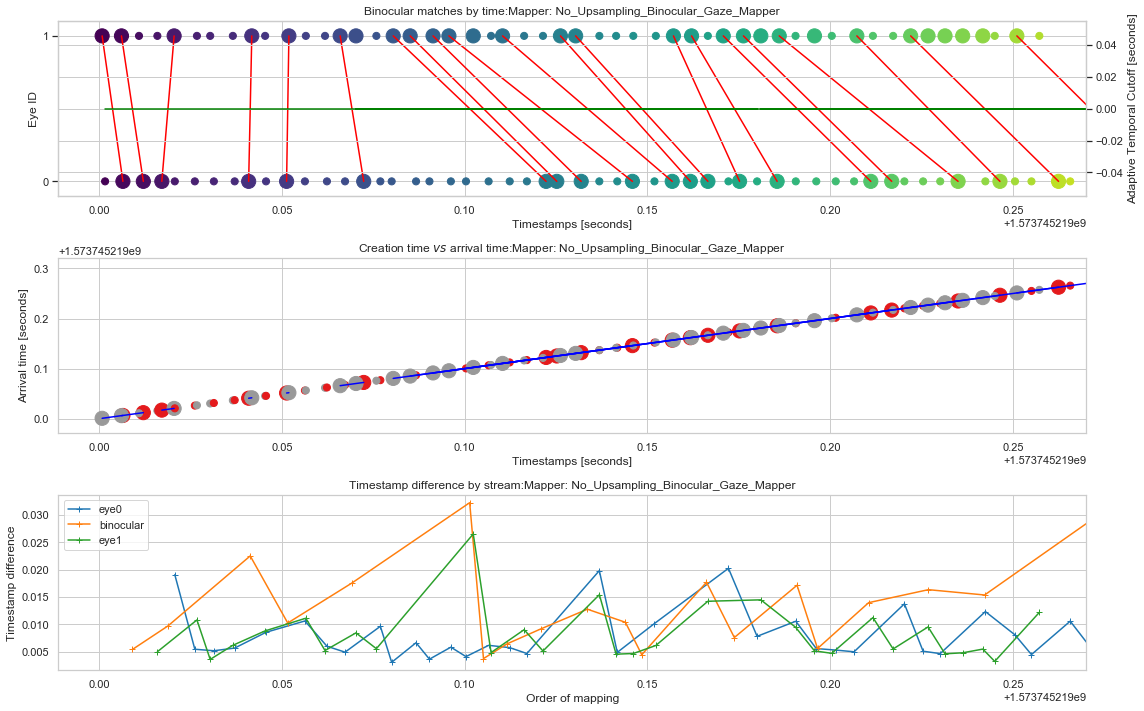

Dynamic_Cutoff_Binocular_Gaze_Mapper


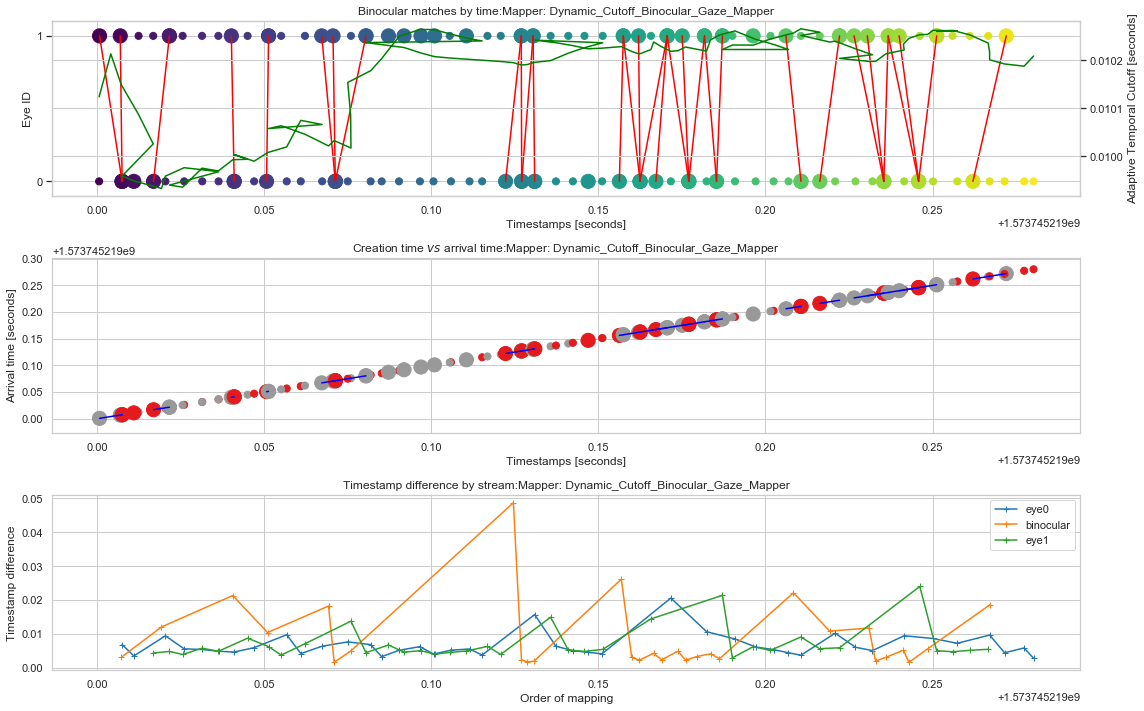

In [8]:
evaluate_gaze_mappers(
    both_timestamp_fps=200,
    binocular_data_mixer=custom_binocular_mixer(
        sample_count=sample_count,
        both_camera_jitter_range=(0, 1 / 400),
        both_transport_jitter_range=(0, 0),
        eye0_transport_delay=0.0,
    ),
    eye0_confidence_stream=generate_uniform_numbers(),
    eye1_confidence_stream=generate_uniform_numbers(),
)

### Case 3: Ideal case
Different framerates, no jitter

v1_18_Binocular_Gaze_Mapper


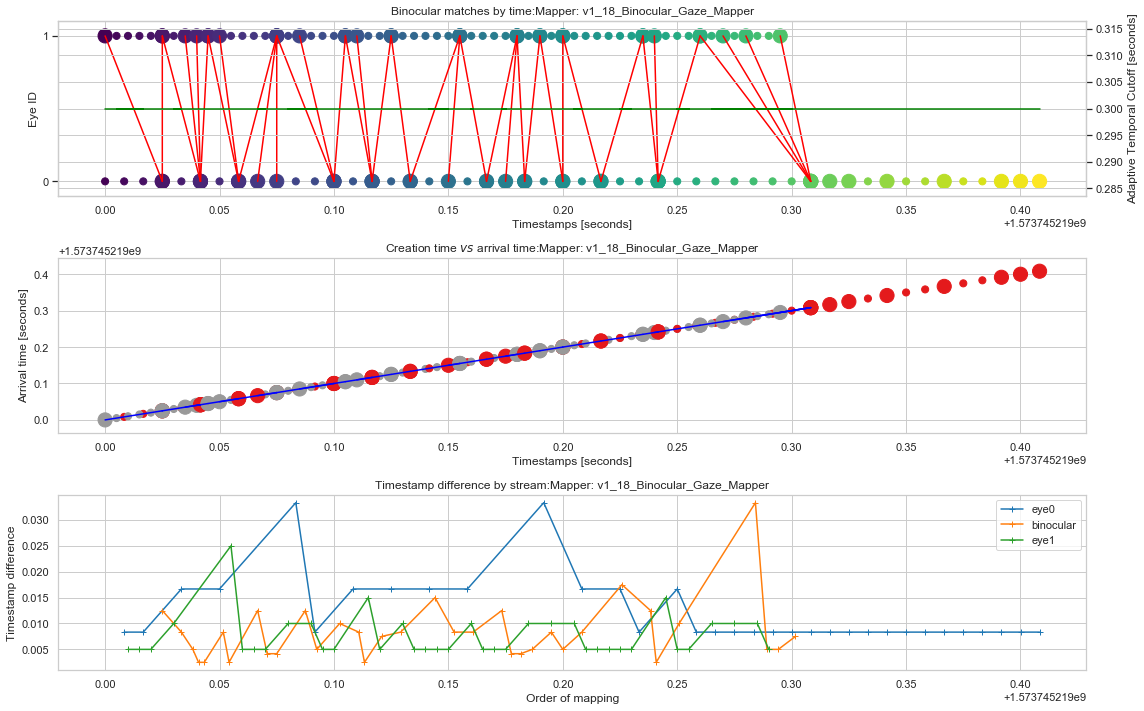

Monotonic_Binocular_Gaze_Mapper


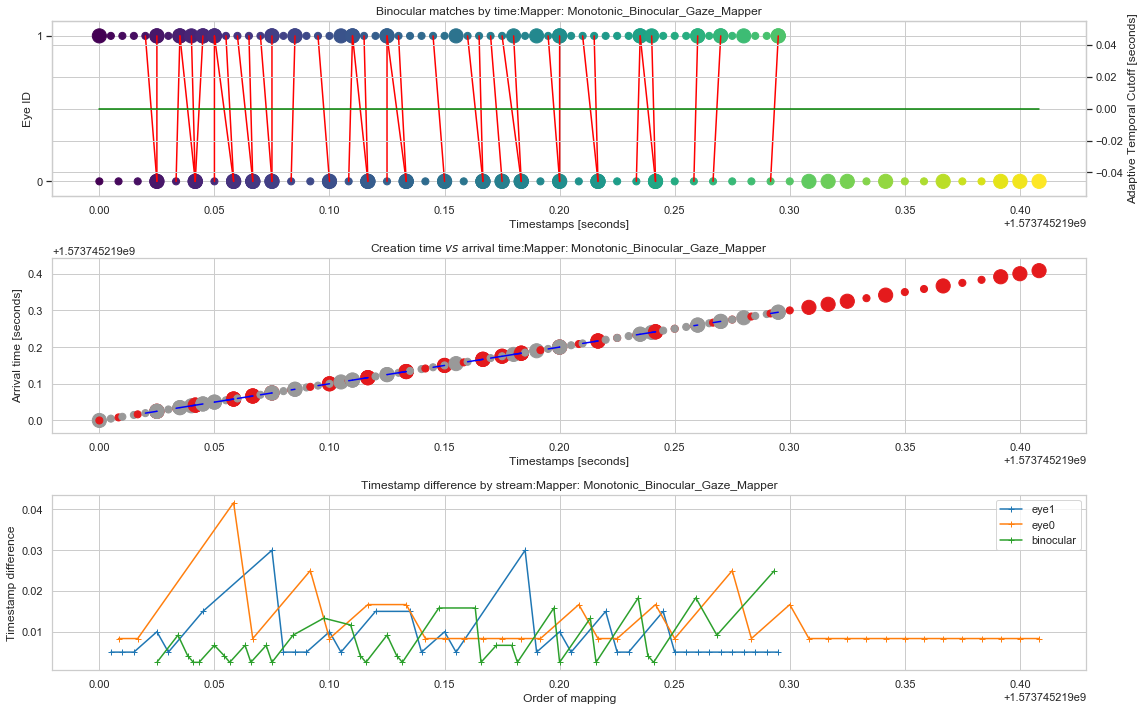

No_Upsampling_Binocular_Gaze_Mapper


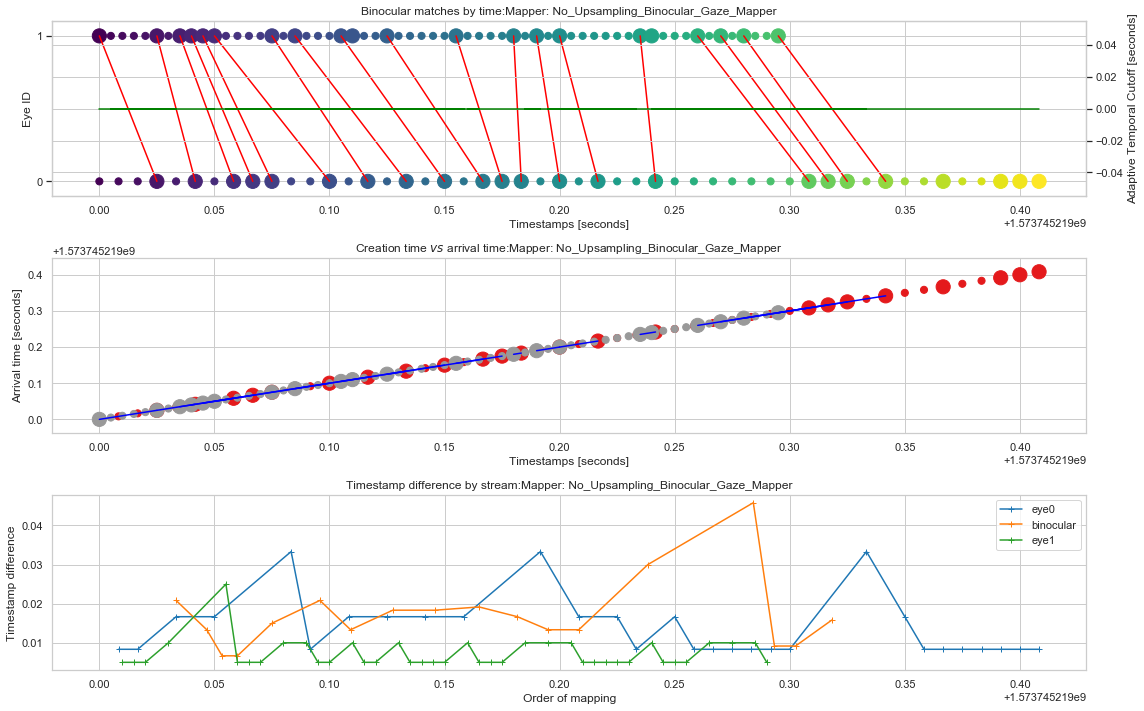

Dynamic_Cutoff_Binocular_Gaze_Mapper


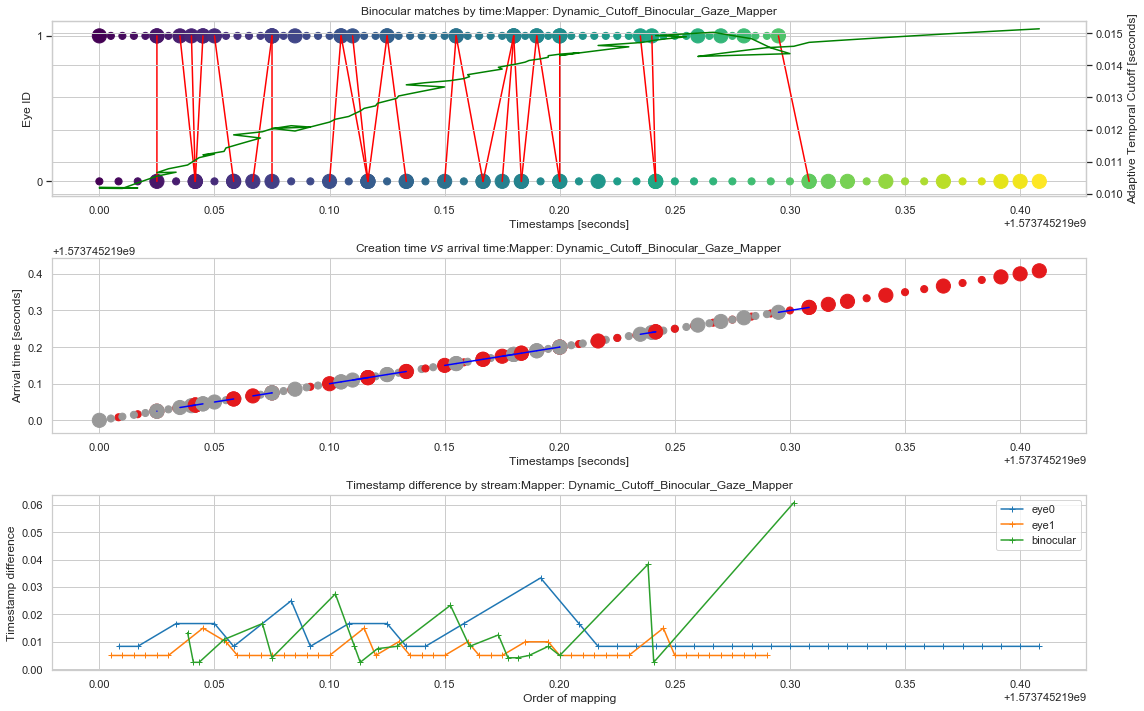

In [9]:
evaluate_gaze_mappers(
    eye0_timestamp_fps=120,
    eye1_timestamp_fps=200,
    binocular_data_mixer=custom_binocular_mixer(
        sample_count=sample_count,
        both_camera_jitter_range=(0, 0),
        both_transport_jitter_range=(0, 0),
        eye0_transport_delay=0.0,
    ),
    eye0_confidence_stream=generate_uniform_numbers(),
    eye1_confidence_stream=generate_uniform_numbers(),
)

### Case 4: Different case
Same framerates, camera jitter, transport delay, no transport jitter

v1_18_Binocular_Gaze_Mapper


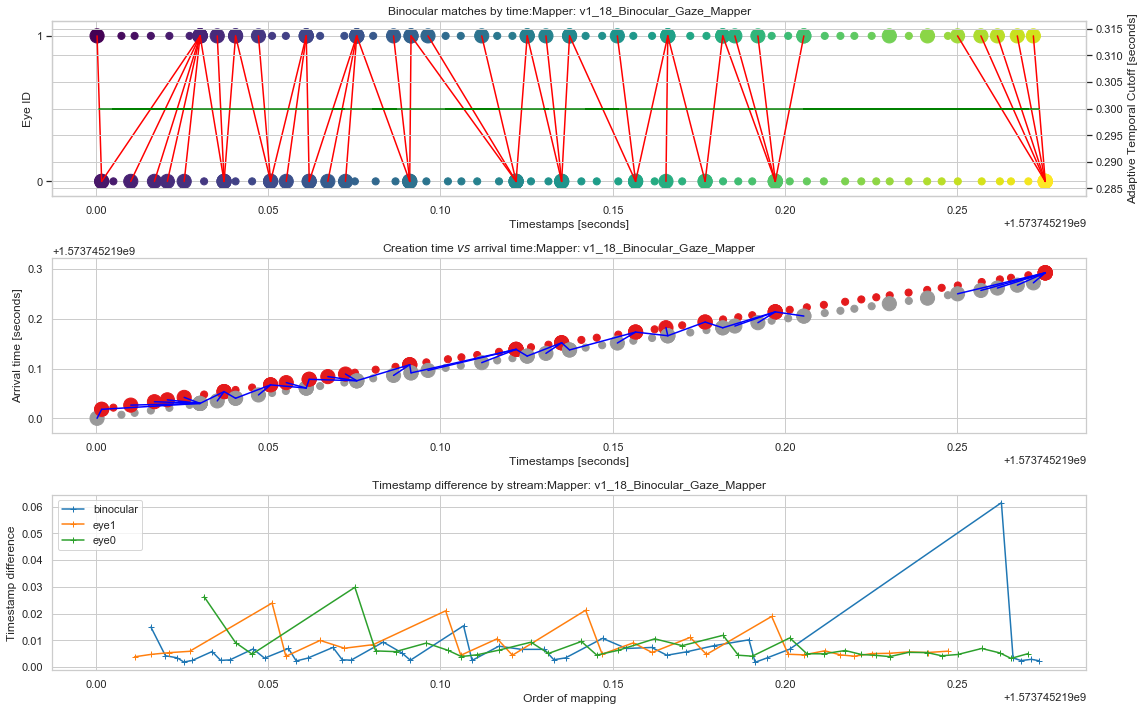

Monotonic_Binocular_Gaze_Mapper


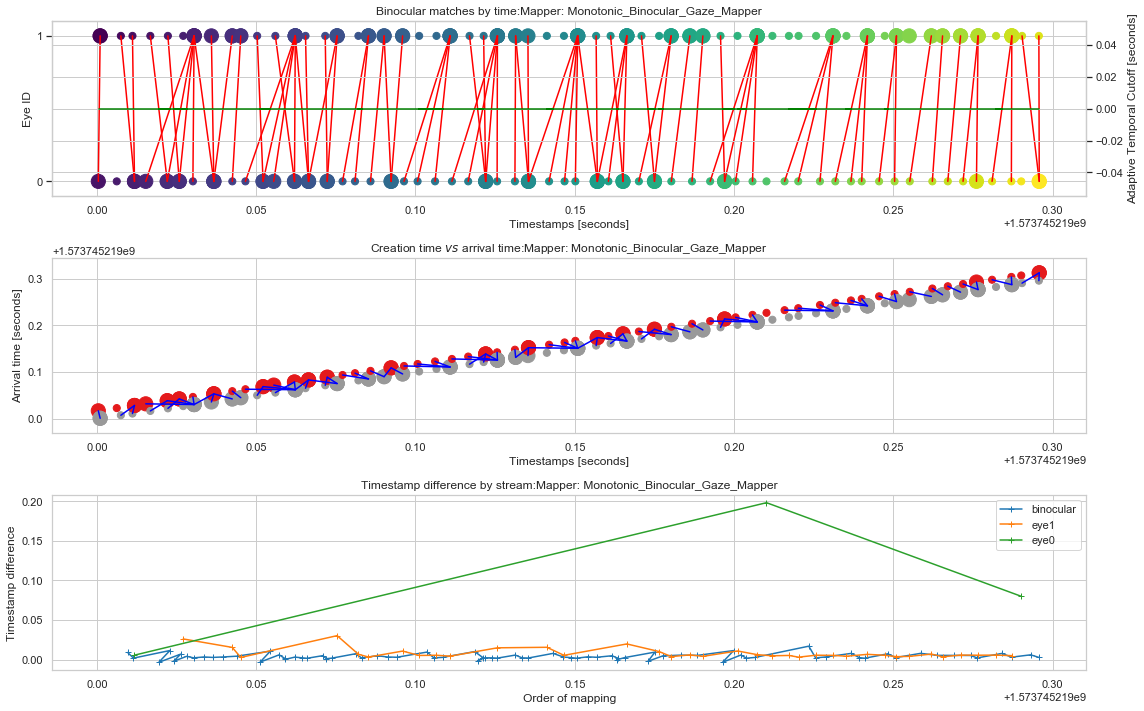

No_Upsampling_Binocular_Gaze_Mapper


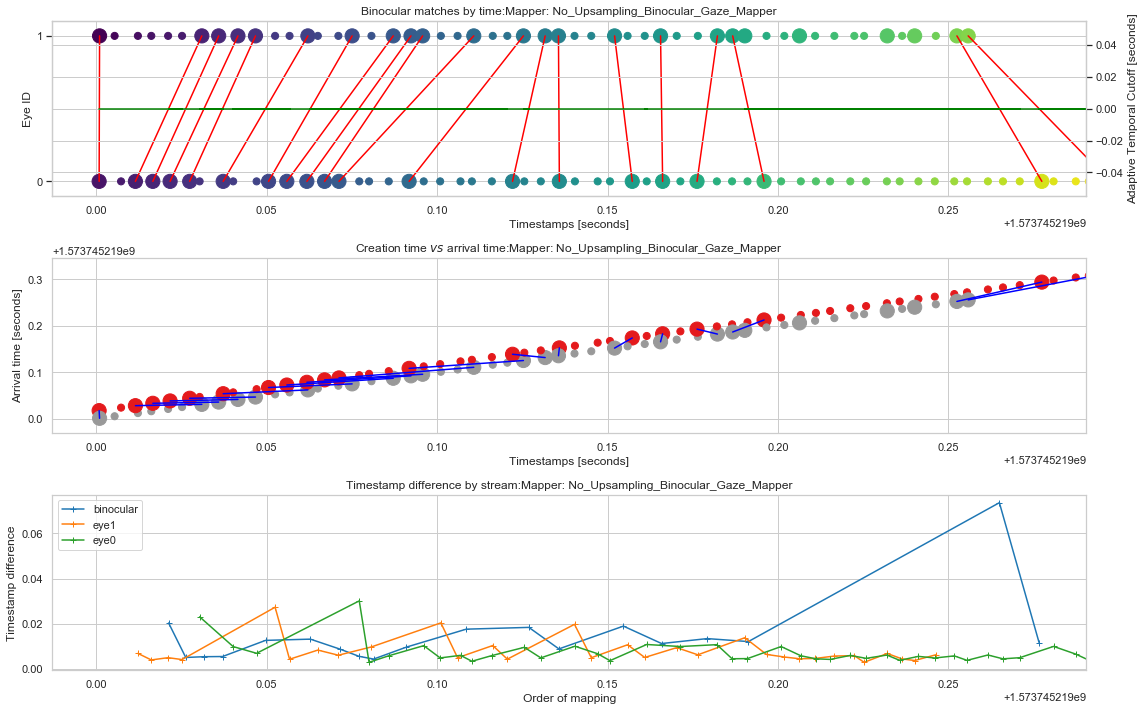

Dynamic_Cutoff_Binocular_Gaze_Mapper


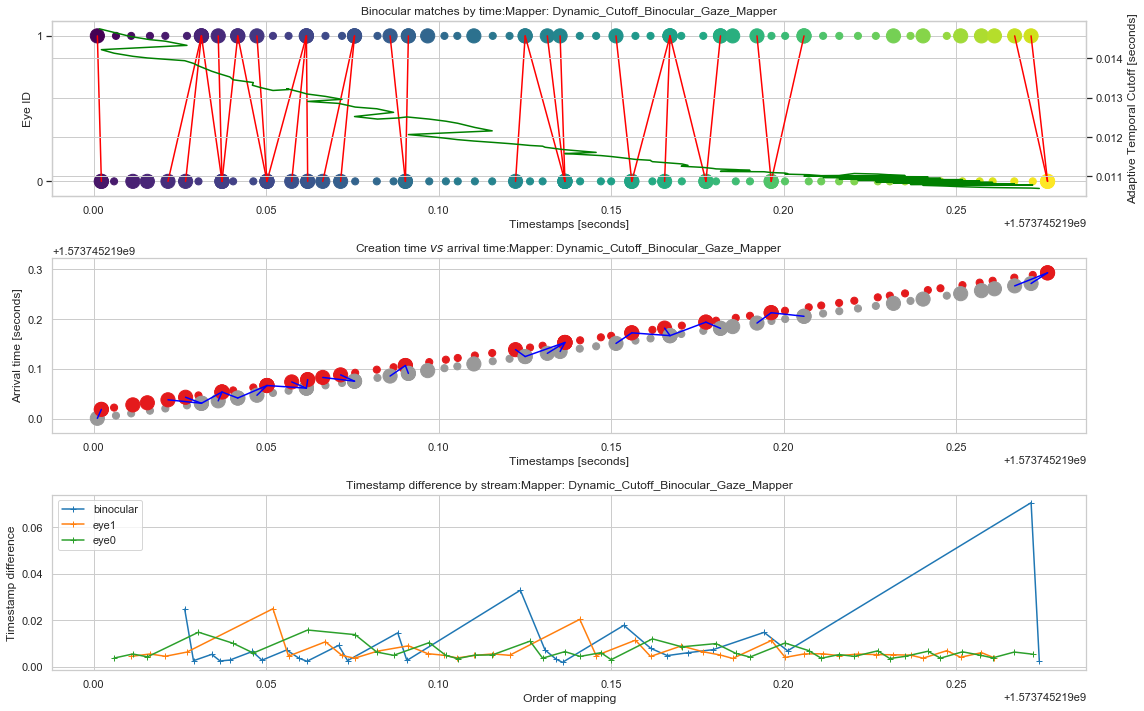

In [10]:
evaluate_gaze_mappers(
    both_timestamp_fps=200,
    binocular_data_mixer=custom_binocular_mixer(
        sample_count=sample_count,
        both_camera_jitter_range=(0, 1 / 400),
        both_transport_jitter_range=(0, 0),
        eye0_transport_delay=1 / 60,
    ),
    eye0_confidence_stream=generate_uniform_numbers(),
    eye1_confidence_stream=generate_uniform_numbers(),
)

## Real world data

We used Pupil Capture `v1.18-38-gcf8b845d` to record a short sequence (~15 seconds) of real world pupil data. You can find the recording data attached.

The relevant difference to the released Pupil Capture `v1.18-35-gfb5c594`, is that the gaze mapper writes the additional `arrival_time` into each pupil datum.

In [11]:
from utils import load_pldata_file

### Recorded gaze data
First we plot the recorded gaze data as sanity check. It should be equivalent to remapping the recorded pupil data with `Old_Binocular_Gaze_Mapper()`.

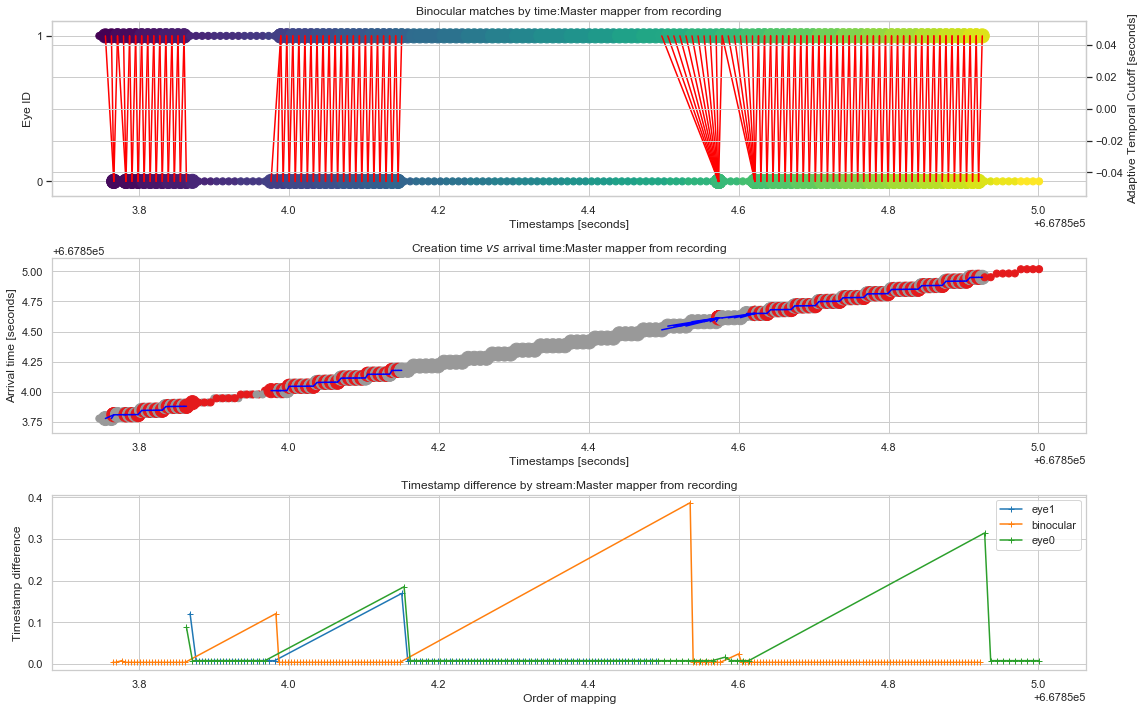

In [12]:
rec_gaze = load_pldata_file("recordings/000/", "gaze").data
plot_mapped_gaze_data(rec_gaze[1600:1900], title=f"Master mapper from recording")
del rec_gaze

### Mapping recorded pupil data
Now we read the recorded pupil data, which contains the additional `arrival_time` key, and map them different matching algorithms.

v1_18_Binocular_Gaze_Mapper


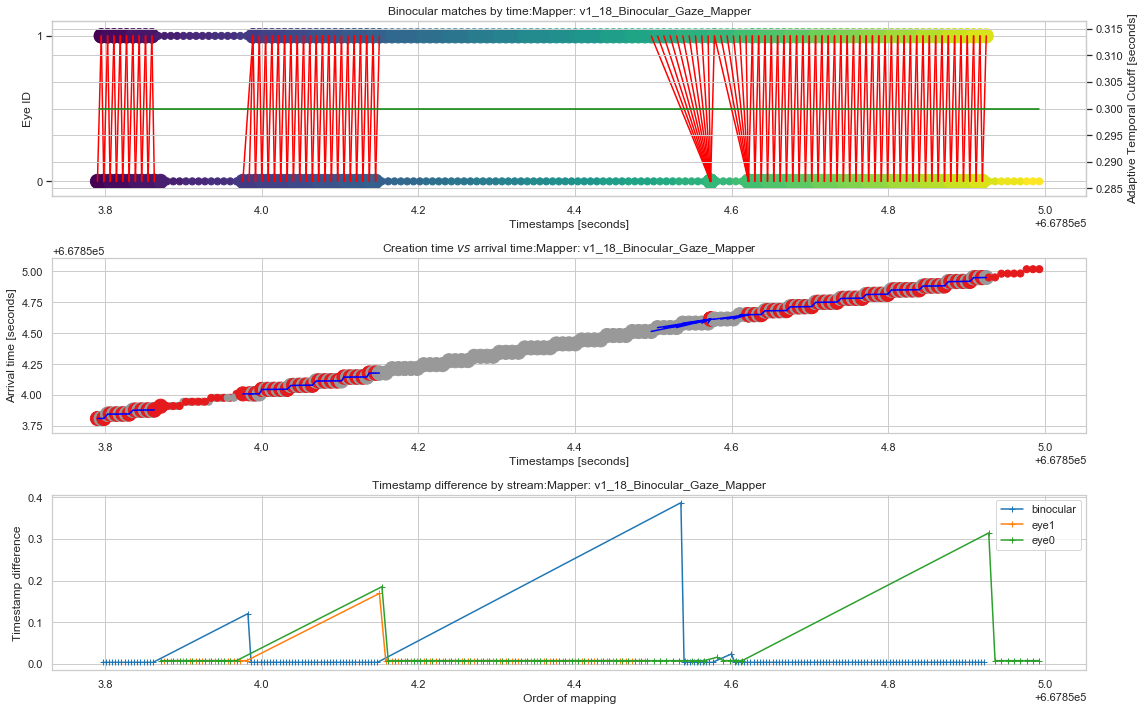

Monotonic_Binocular_Gaze_Mapper


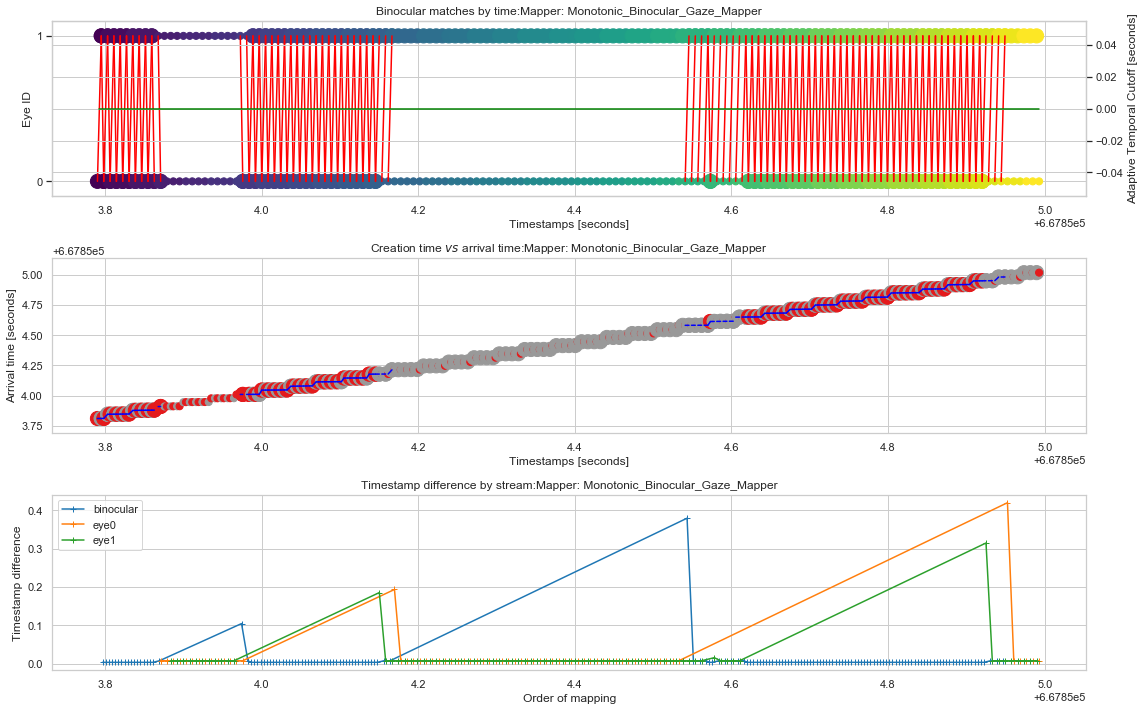

No_Upsampling_Binocular_Gaze_Mapper


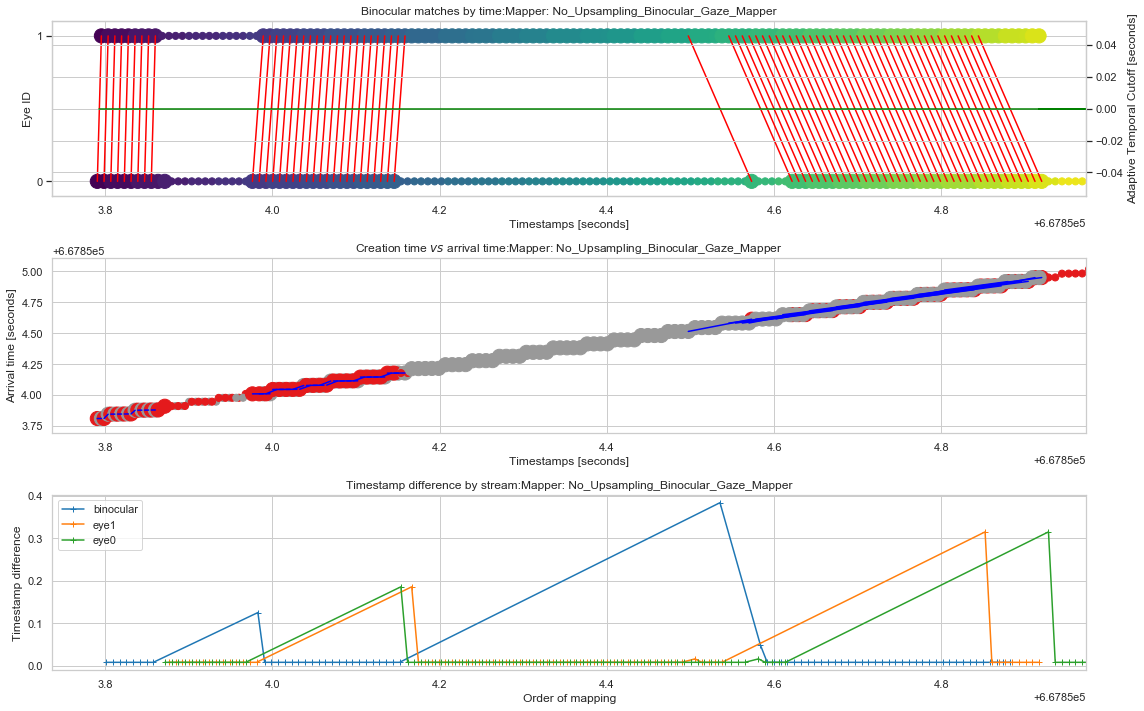

Dynamic_Cutoff_Binocular_Gaze_Mapper


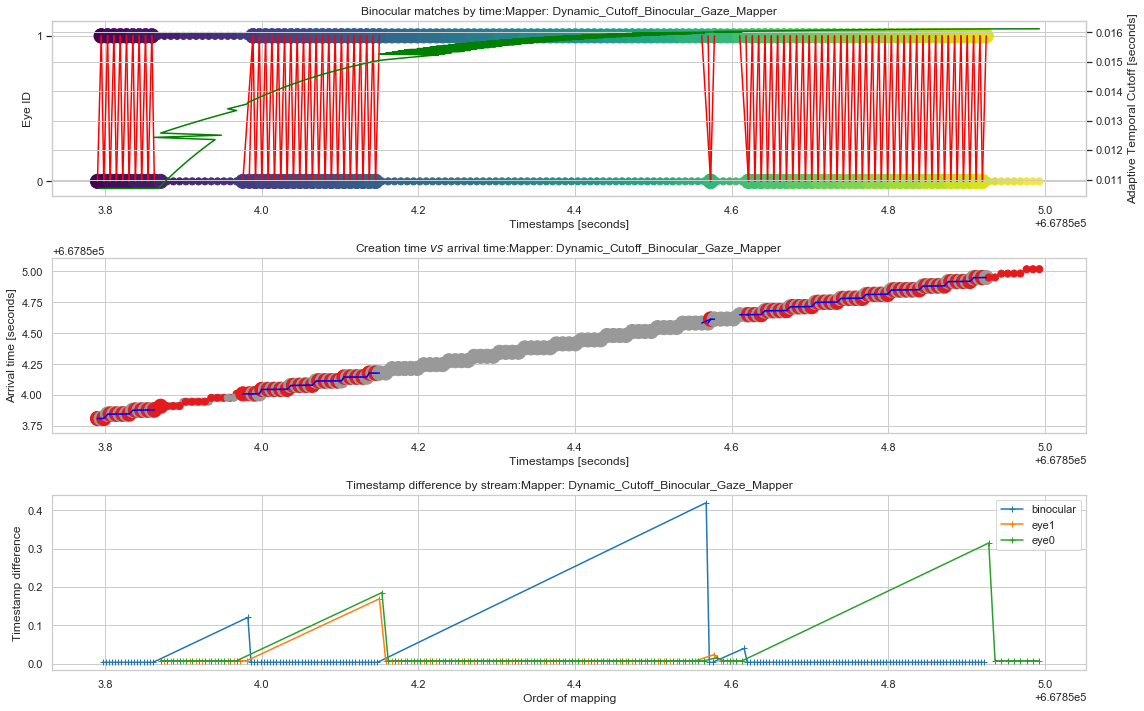

In [14]:
from utils import plt

rec_pupil = load_pldata_file("recordings/000/", "pupil").data


for gaze_mapper in GAZE_MAPPERS:
    mapper_name = type(gaze_mapper).__name__
    print(mapper_name)
    mapped_data = gaze_mapper.map_batch(rec_pupil[1600:1900])
    plot_mapped_gaze_data(mapped_data, title=f"Mapper: {mapper_name}")
    plt.show()
    del mapped_data

del rec_pupil

## Discussion
### v1.18 Gaze Mapper
The v1.18 gaze mapper suffers from a fixed temporal cutoff that is set to 0.3 seconds. In some case, this results  in some pupil data being matched with 0.3 seconds worth of opposite eye pupil data. We consider this to be to high. Two solutions, preventing the reusage of pupil data and dynamic temporal cutoffs, will be discussed below.

### Monotonic Gaze Mapper
The monotonic gaze mapper tries to solve the issue of yielding monocular and binocular gaze data such that their timestamps are monotonically increasing. It has been included for reference purposes.

Unfortunately, the implementation matches low and high confidence pupil data which potentially can deteriorate the spatial gaze mapping accuracy.

### No-upsampling Gaze Mapper
This implementation avoids mapping a single pupil datum twice. This can cause a constant temporal offset of the matched pupil data. This is not desired.

### Dynamic-temporal-cutoff Gaze Mapper
This gaze mapper adapts its temporal cutoff depending on the incoming pupil sampling rate. This still results in some pupil data being used multiple times but not as heaviliy as in the v1.18 gaze mapper.

This version displays the most desirable behaviour for us right now. **Therefore, we will use it to replace the v1.18 gaze mapper** and close the other two PRs.

## Future work
Every future gaze matching algorithm should be evaluated using this notebook before it is being merged into the Pupil code base.